# 프로젝트: 인물 모드 문제점 찾기
==============================================================================

## 목차

### 1. 인물사진 블러 처리 하기
>#### 1.1 이미지 및 모델 준비
>#### 1.2 데이터 정제
>#### 1.3 결과 확인

### 2. 동물사진 블러 처리 하기
>#### 2.1 이미지 및 모델 준비
>#### 2.2 데이터 정제
>#### 2.3 결과 확인

### 3. 크로마키 배경 설정하기
>#### 3.1 이미지 및 모델 준비
>#### 3.2 데이터 정제
>#### 3.3 결과 확인
>#### 3.4 다른 배경 크로마키 적용하기

### 4. 좀 더 쉽게 만들어보자

### 5. 문제점 찾기

### 6. 문제점 해결 방안

### 7. 회고

### 8. Reference

### 9. 자기다짐 및 아쉬운 점

---

## 루브릭 달성 조건

- 1. 인물모드 사진을 성공적으로 제작하였다.
   - 아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
   
- 2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
   - 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
   
- 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
   - semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.
   
---

## 1. 인물사진 블러 처리 하기

### 1.1 이미지 및 모델 준비

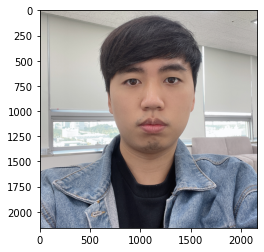

In [1]:
import os
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

img_path= './images/img_00.JPG'  
img_orig = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
model_dir = './models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

- 이미지와 모델을 우선 준비하도록 하겠습니다.

### 1.2 데이터 정제

In [3]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

- 모델을 후에 사용할 segvalues와 output으로 분류하겠습니다.

In [4]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 현재 모델엔 21개의 라벨이 분류되어있습니다.

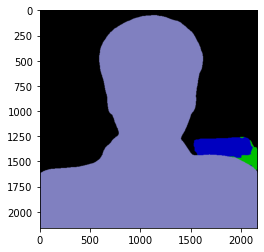

In [5]:
plt.imshow(output)
plt.show()

- 색깔로 분류된것이 4개나 보이는군요
- 각 검은색, 파란색, 초록색, 남색 같은 느낌인데 뭔지 확인해보겠습니다

In [6]:
segvalues

{'class_ids': array([ 0,  9, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

- 0, 9, 15, 18번 클래스들이군요
- 무엇을 의미하는지 확인해보겠습니다.

In [7]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
sofa


- 배경, 의자, 사람, 소파를 나타내는것이었습니다.

In [8]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

In [9]:
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- for문을 통해 colormap에 클래스별 색상값을 넣도록 하겠습니다. 참고로 이 색상은 BGR 값입니다.

In [10]:
print(colormap[0]) # 배경
print(colormap[9]) # 의자
print(colormap[15]) # 사람
print(colormap[18]) # 소파

[0 0 0]
[192   0   0]
[192 128 128]
[  0 192   0]


- 각각 의 colormap을 확인해봤는데요. 저흰 사람의 색상값을 사용할 것이니 추출해주도록 하겠습니다.

In [11]:
seg_color = (128,128,192)

- BGR(192,128,128) 의 구성이었으니 RGB(128,128,192) 의 순서로 튜플로 저장하도록 하겠습니다.

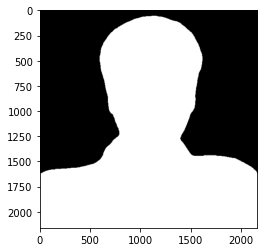

In [12]:
seg_map = np.all(output==seg_color, axis=-1)
plt.imshow(seg_map, cmap='gray')
plt.show()

- 이미지의 마스크를 구분해줄 seg_map 변수를 만들었습니다. 
- output과 동일하게 적용해 사람부분만 추출하도록 하였습니다.

In [13]:
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

- 만들어진 seg_map에서 사람과 배경을 구분하기 위해 *255를 해줍니다.
- 사람이 있는부분은 True == 1, 배경은 False == 0 이었기 때문에 255를 곱해주면 0과 255로 대조되어 구분됩니다.

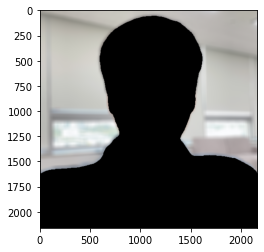

In [14]:
img_orig_blur = cv2.blur(img_orig, (50,50))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 블러 처리는 cv2의 blur 함수를 이용하여 (50, 50) 으로 해주고 배경에 사람의 마스크를 구분해놓은 img_mask를 이용하여 위치 구분을 해주도록 하겠습니다.
  
  
- 잘 처리가 되었군요.

### 1.4 결과 확인

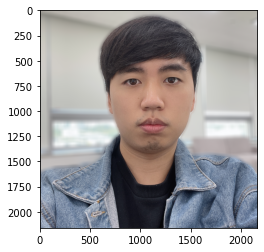

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- exp 7번에서 사용했던 np.where를 이용하여 img_mask_color가 255인 부분에만 원본 이미지를 붙여넣고 그렇지 않은 부분은 blur 처리한 배경을 붙여넣었습니다. 
- 마지막으로 RGB로 변환해주니 사진이 완성되었군요

---
## 2. 동물 사진 블러 처리하기

### 2.1 이미지 및 모델 준비

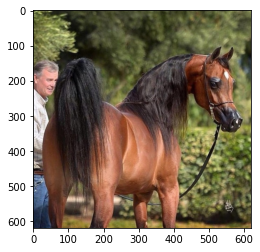

In [16]:
horse_path= './images/horse.jfif'  
img_orig = cv2.imread(horse_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 자 이번엔 말사진을 통해 블러처리를 해보도록 하겠습니다.

### 2.2 데이터 정제

In [17]:
segvalues, output = model.segmentAsPascalvoc(horse_path)

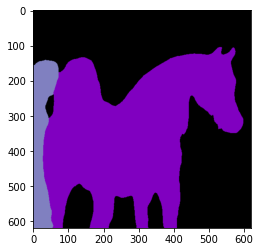

In [18]:
plt.imshow(output)
plt.show()

- 사람 블러처리할때와 똑같이 구분해주었습니다.

In [19]:
segvalues

{'class_ids': array([ 0, 13, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [20]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
horse
person


- 이번엔 horse를 잘 구분해냈군요

In [21]:
print(colormap[0]) # 배경
print(colormap[13]) # 말
print(colormap[15]) # 사람

[0 0 0]
[192   0 128]
[192 128 128]


In [22]:
seg_color_horse = (128,0,192)

- 이번에는 말을 사용할것이기에 말의 색상값을 RGB 형태로 변환하여 담아줍니다.

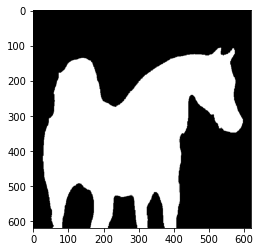

In [23]:
seg_map_horse = np.all(output==seg_color_horse, axis=-1)
plt.imshow(seg_map_horse, cmap='gray')
plt.show()

In [24]:
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_horse = seg_map_horse.astype(np.uint8) * 255

img_orig_blur = cv2.blur(img_orig, (50,50))

horse_mask_color = cv2.cvtColor(img_mask_horse, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(horse_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

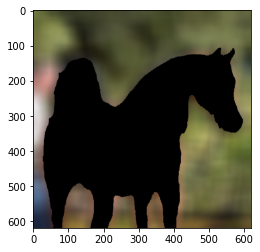

In [25]:
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 각 변수들에 잘 할당된 모습을 볼 수 있습니다.

### 2.3 결과 확인

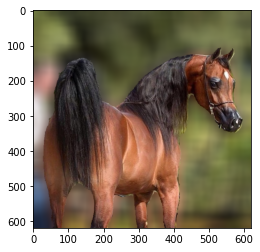

In [26]:
horse_concat = np.where(horse_mask_color == 255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(horse_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 말이 늠름하게 서있고 주변으로 블러처리가 아주 잘되었습니다.
- 배경때문일까요? 오히려 말이 훨씬 깔끔하게 구분되었습니다.

---
### 3. 크로마키 배경 설정하기

#### 3.1 이미지 및 모델 설정하기

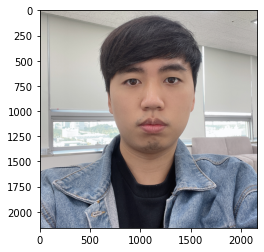

In [27]:
img_orig = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

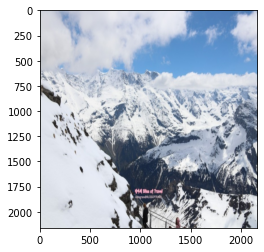

In [28]:
swiss_img = './images/swiss.jfif'
swiss_orig = cv2.imread(swiss_img)
swiss_orig = cv2.resize(swiss_orig, (img_orig.shape[0],img_orig.shape[1]))
plt.imshow(cv2.cvtColor(swiss_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 자 이번엔 블러가 아닌 크로마키 배경을 설정해보겠습니다.
- 이미지는 위와 동일한 이미지를 사용하겠습니다.
- 배경은 한번 스위스로 가보겠습니다!

#### 3.2 데이터 정제

In [29]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [30]:
print(colormap[15]) # 사람

[192 128 128]


In [31]:
seg_color = (128,128,192)

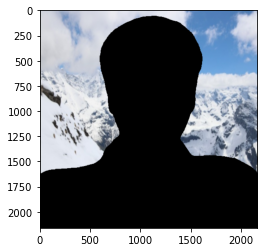

In [32]:
img_orig_blur = cv2.blur(swiss_orig, (8,8))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 위와 동일한 과정을 거쳐 배경이미지가 잘 추출되었군요!
- 원본 이미지와 한번 결합해보도록 하겠습니다.

#### 3.3 결과 확인

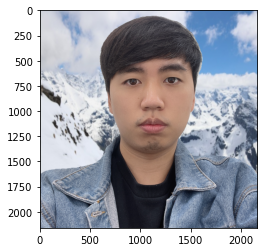

In [33]:
swiss_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(swiss_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 눈덮인 스위스의 한 설산 앞으로 이동하였습니다
- 아주 재밌는 기능인것 같습니다.

#### 3.4 다른 배경 크로마키 적용하기

In [34]:
italy_img = './images/italy.jfif'
italy_orig = cv2.imread(italy_img)
italy_orig = cv2.resize(italy_orig, (img_orig.shape[0],img_orig.shape[1]))

- 자 이번엔 다른곳도 가볼까요?

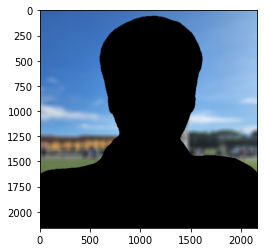

In [35]:
img_orig_blur = cv2.blur(italy_orig, (50,50))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 자 이번엔 이탈리아의 피사의사탑 앞입니다만.. 제가 사진을 너무 많이 가리고 찍었나봅니다.

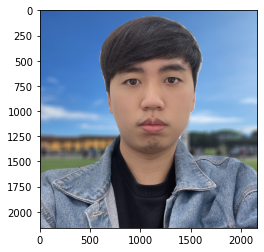

In [36]:
italy_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(italy_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 그래도 아주 잘 합성되는 모습을 볼 수 있습니다!

---
### 4. 좀 더 쉽게 만들어보자

- 좀 더 쉽고 간편하게 만들어볼순 없을까요?
- 클래스화해서 더욱 간편하게 만들어보도록 하겠습니다.

In [37]:
class camera:
    def __init__(self):
        print('이 클래스를 이용하기 위해선 아래의 라이브러리가 필요합니다.')
        print('\n')
        print('import cv2')
        print('import numpy as np')
        print('import matplotlib.pyplot as plt')
        print('import os')
        print('from pixellib.semantic import semantic_segmentation')
        print('\n')
        print('위 라이브러리를 불러온 후 이용해주십시오.')
        
    def blur(self, img_path, model_path):
        # 이미지 및 모델 준비
        img_orig = cv2.imread(img_path)
        img_orig = cv2.resize(img_orig, (img_orig.shape[0],img_orig.shape[0]))
        model_file = os.path.join(model_path, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
        model = semantic_segmentation()
        model.load_pascalvoc_model(model_file)
        
        segvalues, output = model.segmentAsPascalvoc(img_path)
        output = cv2.resize(output, (img_orig.shape[0], img_orig.shape[0]))
        # 라벨은 21개
        LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 
                       'boat', 'bottle', 'bus','car', 'cat', 'chair', 
                       'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                       'person', 'pottedplant', 'sheep', 'sofa', 'train', 
                       'tv']        
        
        colormap = np.zeros((256, 3), dtype = int)
        ind = np.arange(256, dtype=int)
        
        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        
        for index, class_id in enumerate(segvalues['class_ids']):
            if LABEL_NAMES[class_id] == 'person':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break
            elif LABEL_NAMES[class_id] == 'aeroplane':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break              
            elif LABEL_NAMES[class_id] == 'bicycle':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'boat':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'bus':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'car':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'motorbike':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'train':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'bird':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break
            elif LABEL_NAMES[class_id] == 'cat':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'cow':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'dog':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'horse':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'sheep':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break                
        
        seg_map = np.all(output==seg_color, axis=-1)
        
        img_mask = seg_map.astype(np.uint8) * 255
        
        img_orig_blur = cv2.blur(img_orig, (32,32))

        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

        img_bg_mask = cv2.bitwise_not(img_mask_color)

        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
        
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()

    def chromakey(self, img_path, model_path, bg_path):
        # 이미지 및 모델 준비
        img_orig = cv2.imread(img_path)
        img_orig = cv2.resize(img_orig, (img_orig.shape[0],img_orig.shape[0]))
        model_file = os.path.join(model_path, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
        model = semantic_segmentation()
        model.load_pascalvoc_model(model_file)
        
        segvalues, output = model.segmentAsPascalvoc(img_path)
        output = cv2.resize(output, (img_orig.shape[0], img_orig.shape[0]))
        # 라벨은 21개
        LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 
                       'boat', 'bottle', 'bus','car', 'cat', 'chair', 
                       'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                       'person', 'pottedplant', 'sheep', 'sofa', 'train', 
                       'tv']        
        
        colormap = np.zeros((256, 3), dtype = int)
        ind = np.arange(256, dtype=int)
        
        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3

        for index, class_id in enumerate(segvalues['class_ids']):
            if LABEL_NAMES[class_id] == 'person':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break
            elif LABEL_NAMES[class_id] == 'aeroplane':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break              
            elif LABEL_NAMES[class_id] == 'bicycle':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'boat':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'bus':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'car':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'motorbike':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'train':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break                
            elif LABEL_NAMES[class_id] == 'bird':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)
                break
            elif LABEL_NAMES[class_id] == 'cat':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'cow':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'dog':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'horse':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break
            elif LABEL_NAMES[class_id] == 'sheep':
                target = segvalues['class_ids'][index]
                c,b,a = colormap[target]
                seg_color = (a,b,c)                
                break                 
        
        seg_map = np.all(output==seg_color, axis=-1)
        
        img_mask = seg_map.astype(np.uint8) * 255
        
        bg_orig = cv2.imread(bg_path)
        bg_orig = cv2.resize(bg_orig, (img_orig.shape[0],img_orig.shape[1]))
        
        img_orig_blur = cv2.blur(bg_orig, (6,6))

        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

        img_bg_mask = cv2.bitwise_not(img_mask_color)

        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
        
        img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()        

- 자 클래스를 만들었습니다.
  
  
- 위의 코드의 함축에 가깝지만 for문을 통해 seg_color를 자동으로 추출할 수 있도록 하였고 모든 클래스에 접글할 수 있도록 만들었습니다.
  
  
- 또한 각 사진들의 이미지가 일치하지 않으면 bitwise_and에서 사진 결합을 할 때 오류가 발생하기에 모든 사진의 이미지의 x,y 축을 resize하여 통일해 주었습니다.
  
  
- 저희에게 필요한건 사람 혹은 동물의 이미지 경로, 모델의 경로, 배경 경로뿐입니다.
  
  
- 경로들을 불러오도록 하겠습니다.

### 사람과 모델 이미지

In [38]:
person_path= './images/img_00.JPG'  
model_path = './models' 

- 아까 사용했던 사람 이미지와 모델의 경로를 지정해주겠습니다.

### 동물 이미지

In [39]:
cat_path = './images/cat.jfif'
horse_path= './images/horse.jfif'  
cow_path = './images/cow.jfif'
sheep_path = './images/sheep.jfif'
dog_path = './images/dog.jfif'
bird_path = './images/bird.jfif'

- 자 동물들을 데려왔습니다.
- 고양이, 말, 소, 양, 개, 새 6마리를 데려왔습니다.

### 탈 것 이미지

In [40]:
bus_path = './images/bus.jfif'
car_path = './images/car.jfif'
train_path = './images/train.jfif'
aeroplane_path = './images/aeroplane.jfif'
boat_path = './images/boat.jfif'
bicycle_path = './images/bicycle.jfif'
motorbike_path = './images/motorbike.jfif'

- 자 탈것도 구분해보겠습니다.
- 버스, 차, 기차, 비행기, 배, 자전거, 오토바이를 가져왔습니다.

### 배경 이미지

In [41]:
field_path = './images/field.jfif'
swiss_path = './images/swiss.jfif'
sky_path = './images/sky.jfif'
space_path = './images/space.jfif'
ocean_path = './images/ocean.jfif'

- 여러곳도 가봐야할듯합니다. 사람보단 동물이 더 많으니 동물들을 위한 배경을 불러와줍니다.
  
  
- 초원, 스위스, 하늘, 우주, 바다의 배경을 가져왔습니다.

### 4.1 적용해보기

- 적용해보겠습니다.

In [42]:
camera = camera()

이 클래스를 이용하기 위해선 아래의 라이브러리가 필요합니다.


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pixellib.semantic import semantic_segmentation


위 라이브러리를 불러온 후 이용해주십시오.


- 클래스를 사용하기위해선 모듈들이 필요합니다!
  
  
- 클래스 내부에 모듈을 집어넣어 따로 import하지 않을 수 있도록 할 순 있지만 그렇게되면 클래스가 무거워지고 오래걸리기에 문구로 대체하였습니다.
  
  
- 필요한 모듈을 간편하게 import할 수 있도록 하였습니다.

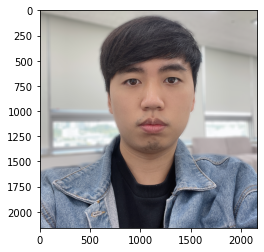

In [43]:
camera.blur(img_path, model_path)

- 자 사람에 대한 블러는 잘되는군요!
- 크로마키는 어떨까요?

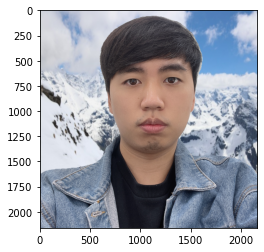

In [44]:
camera.chromakey(img_path, model_path, swiss_img)

- 크로마키도 아주 잘되는군요.

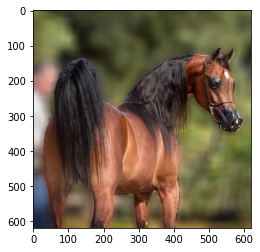

In [45]:
camera.blur(horse_path, model_path)

- 동물에 대한 블러처리도 잘되는군요

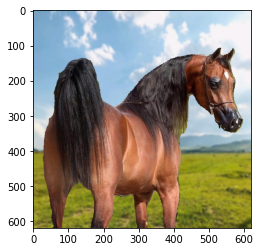

In [46]:
camera.chromakey(horse_path, model_path, field_path)

- 그래서 말을 더 광활한 초원으로 보내주었습니다.
- 더욱 늠름해진 모습을 볼 수 있군요.
  
  
- 하지만 뭔가 경고문구가 뜹니다.
- 아무래도 함수호출과정이 무겁고 비효율적이라는것 같습니다.
- 좀 더 간출이는게 어떻겠냐는 문구인듯 하지만 여기서는 넘어가보도록 하겠습니다.

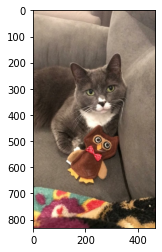

In [47]:
cat_orig = cv2.imread(cat_path)
cat_rgb = cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_rgb)
plt.show()

- 귀여운 고양이도 한마리 데려왔습니다!
- 블러처리를 해보겠습니다.

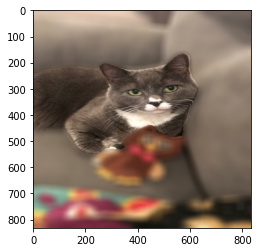

In [48]:
camera.blur(cat_path, model_path)

- 블러처리가 잘 되었군요. 하지만 뭔가 어색합니다.
- 아마도 인형이 가리고있는 고양이의 앞발부분이 잘려서 그런듯합니다.

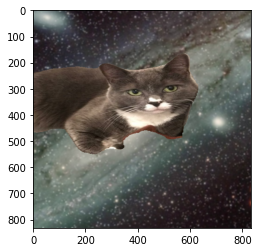

In [49]:
camera.chromakey(cat_path, model_path, space_path)

- 고양이를 우주로도 보내보았습니다. 아주 잘 작동하는군요.

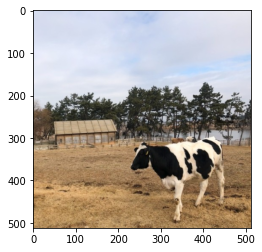

In [50]:
cow_orig = cv2.imread(cow_path)
cow_rgb = cv2.cvtColor(cow_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cow_rgb)
plt.show()

- 이번엔 소를 데려왔습니다.

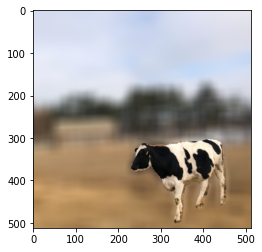

In [51]:
camera.blur(cow_path, model_path)

- 블러처리하며 소도 구분을 잘하는군요.
- 소는 어디로 보내볼까요?

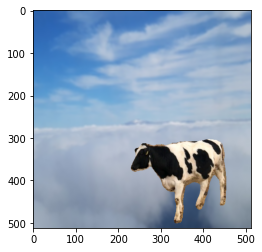

In [52]:
camera.chromakey(cow_path, model_path, sky_path)

- 구름 위로 보내주었습니다.

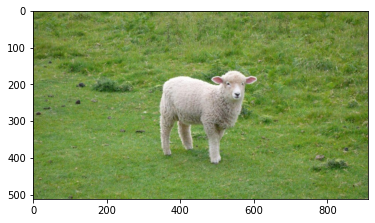

In [53]:
sheep_orig = cv2.imread(sheep_path)
sheep_rgb = cv2.cvtColor(sheep_orig, cv2.COLOR_BGR2RGB)
plt.imshow(sheep_rgb)
plt.show()

- 이번엔 양입니다!

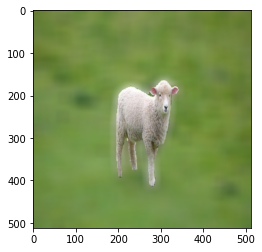

In [54]:
camera.blur(sheep_path, model_path)

- 블러처리도 잘 되는것을 확인할 수 있습니다

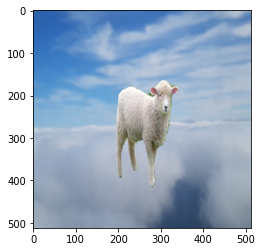

In [55]:
camera.chromakey(sheep_path, model_path, sky_path)

- 크로마키도 잘되는군요.

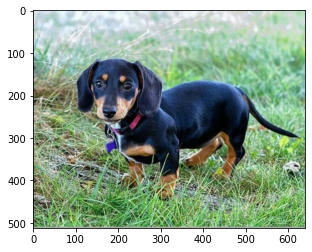

In [56]:
dog_orig = cv2.imread(dog_path)
dog_rgb = cv2.cvtColor(dog_orig, cv2.COLOR_BGR2RGB)
plt.imshow(dog_rgb)
plt.show()

- 이번엔 귀여운 강아지!

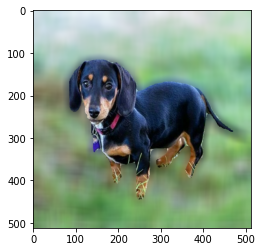

In [57]:
camera.blur(dog_path, model_path)

- 블러처리도 잘 되는것을 볼 수 있습니다.

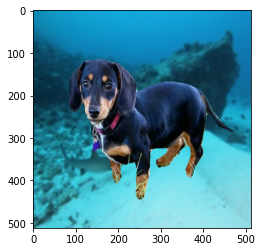

In [58]:
camera.chromakey(dog_path, model_path, ocean_path)

- 크로마키도 잘되는군요.

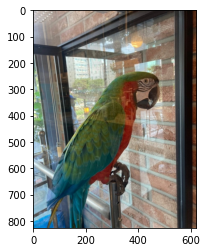

In [59]:
bird_orig = cv2.imread(bird_path)
bird_rgb = cv2.cvtColor(bird_orig, cv2.COLOR_BGR2RGB)
plt.imshow(bird_rgb)
plt.show()

- 이번엔 앵무새입니다.

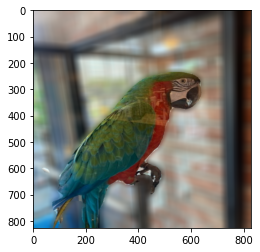

In [60]:
camera.blur(bird_path, model_path)

- 블러처리도 잘 되는군요.

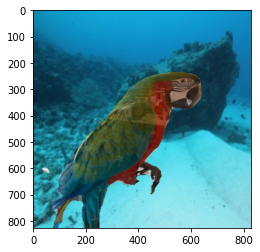

In [61]:
camera.chromakey(bird_path, model_path, ocean_path)

- 바다로 이동도 잘됩니다.

- 여기까지 동물들을 진행하는 과정을 보았을때 생각보다 모델이 너무나도 잘 작동합니다.
- 문제점을 크게 찾을 수가 없군요.
- 위 사진의 앵무새의 발판마저도 구분해내는 아주 놀라운 성능을 보여줍니다.
  
  
- 문제를 더 찾기위해 탈것에 적용해보겠습니다.

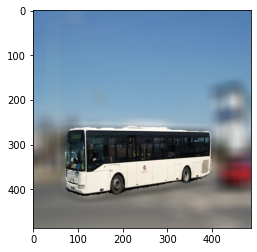

In [62]:
camera.blur(bus_path, model_path)

- 문제라고 할 수 있을까요? 약간 잔상 비슷하게 주변에 보이는데요..
- 좀 애매합니다. 그래도 블러는 아주 잘되는군요!

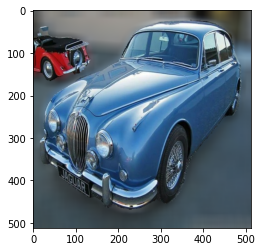

In [63]:
camera.blur(car_path, model_path)

- 이번엔 차에 블러처리를 해보았는데 차가 2대인데도 불구하고 아주 처리를 잘하는군요.
- 왼쪽의 반절이 잘려있지만 또한 차로 구분해주는 모습입니다.

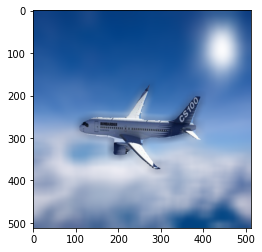

In [64]:
camera.blur(aeroplane_path, model_path)

- 비행기도 처리가 아주 잘되는군요.

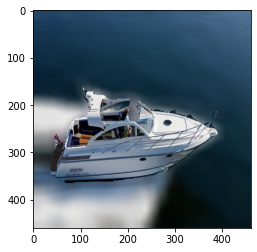

In [65]:
camera.blur(boat_path, model_path)

- 배도 놀랍군요.
- 배 위에있는 아주 작은 사람마저 구분해서 블러처리를 하였습니다.
- 배만 구분해내는 성능이 정말 뛰어납니다.

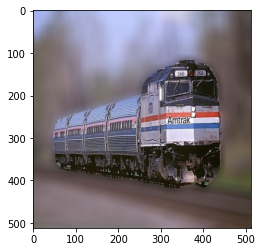

In [66]:
camera.blur(train_path, model_path)

- 기차도 아주 잘 분류하구요

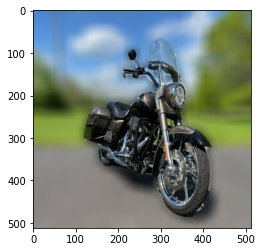

In [67]:
camera.blur(motorbike_path, model_path)

- 오토바이도 완벽합니다.

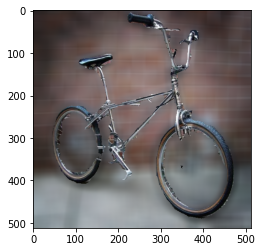

In [68]:
camera.blur(bicycle_path, model_path)

- 자전거는.. 뭔가 이상합니다!
- 바퀴 안쪽의 살들이 안보이는군요 어떻게 된건지 확인해봐야겠습니다.
- 지금까지 아주 잘 구분해주었는데 무엇이 문제일까요?

## 5. 문제점 찾기

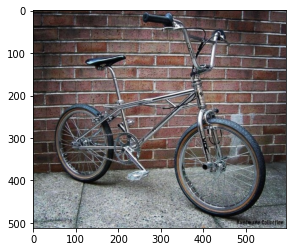

In [69]:
img_orig = cv2.imread(bicycle_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 원본 이미지는 이렇습니다.

In [70]:
segvalues, output = model.segmentAsPascalvoc(bicycle_path)

output.shape

(512, 595, 3)

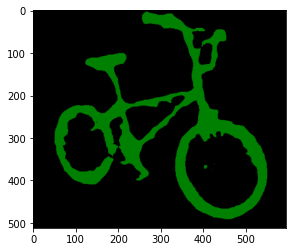

In [71]:
plt.imshow(output)
plt.show()

- 자전거를 잘 구분은 했으나.. 바퀴안의 살들은 자전거로 구분하지 못했군요

In [72]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle


In [73]:
bicycle_02_path = './images/bicycle_02.jfif'
single_bicycle_path = './images/single_bicycle.jfif'

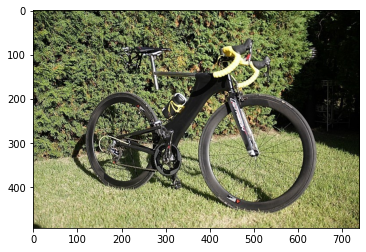

In [74]:
bicycle_orig = cv2.imread(bicycle_02_path)
plt.imshow(cv2.cvtColor(bicycle_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 다른 자전거들은 어떨지 확인해보겠습니다.

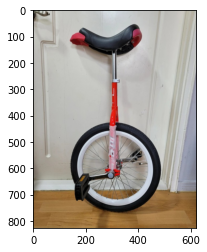

In [75]:
single_orig = cv2.imread(single_bicycle_path)
plt.imshow(cv2.cvtColor(single_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 외발자전건데.. 이것도 자전거로 구분을 할까요?

In [76]:
bi_segvalues, bi_output = model.segmentAsPascalvoc(bicycle_02_path)
sg_segvalues, sg_output = model.segmentAsPascalvoc(single_bicycle_path) 

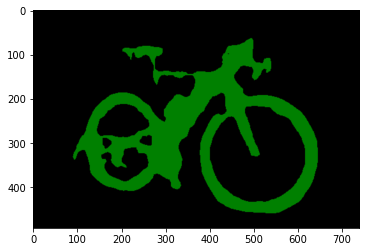

In [77]:
plt.imshow(bi_output)
plt.show()

- output을 잘 구분해냈지만 이역시도 살이 안보이는군요.

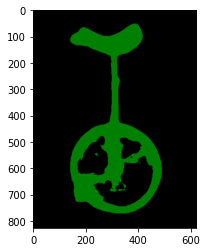

In [78]:
plt.imshow(sg_output)
plt.show()

- 무언가로 구분해냈습니다! 안쪽의 살이 보이지 않는건 여전합니다.

In [79]:
for class_id in bi_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle


In [80]:
for class_id in sg_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle


- 둘 다 자전거로 구분해내는군요.
- 모델 훈련과정에 외발자전거도 포함되어있었던 듯 합니다.

In [81]:
sg_segvalues['class_ids']

array([0, 2])

In [82]:
LABEL_NAMES[2]

'bicycle'

In [83]:
print(colormap[2])

[  0 128   0]


In [84]:
seg_color = tuple(colormap[2])

In [85]:
seg_color

(0, 128, 0)

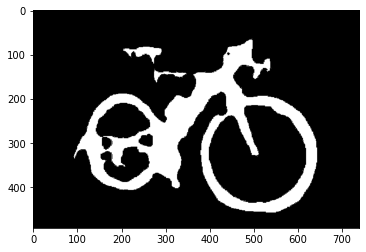

In [86]:
bi_seg_map = np.all(bi_output==seg_color, axis=-1)
plt.imshow(bi_seg_map, cmap='gray')
plt.show()

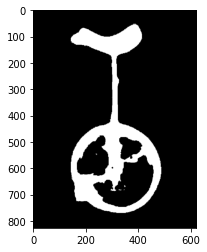

In [87]:
sg_seg_map = np.all(sg_output==seg_color, axis=-1)
plt.imshow(sg_seg_map, cmap='gray')
plt.show()

In [88]:
bi_img_mask = bi_seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(bi_img_mask, cv2.COLORMAP_JET)

In [89]:
sg_img_mask = sg_seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(sg_img_mask, cv2.COLORMAP_JET)

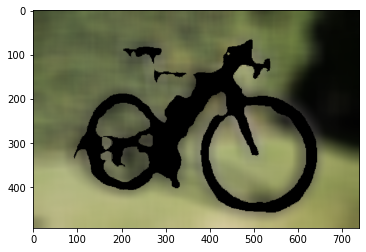

In [90]:
bi_orig_blur = cv2.blur(bicycle_orig, (50,50))
sg_orig_blur = cv2.blur(single_orig, (50,50))

bi_img_mask_color = cv2.cvtColor(bi_img_mask, cv2.COLOR_GRAY2BGR)
sg_img_mask_color = cv2.cvtColor(sg_img_mask, cv2.COLOR_GRAY2BGR)

bi_img_bg_mask = cv2.bitwise_not(bi_img_mask_color)
sg_img_bg_mask = cv2.bitwise_not(sg_img_mask_color)

bi_bg_blur = cv2.bitwise_and(bi_orig_blur, bi_img_bg_mask)
sg_bg_blur = cv2.bitwise_and(sg_orig_blur, sg_img_bg_mask)

plt.imshow(cv2.cvtColor(bi_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 살을 구분해내지 못하니 바퀴 안쪽이 블러처리된 모습을 확인할 수 있습니다.

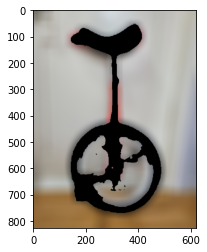

In [91]:
plt.imshow(cv2.cvtColor(sg_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 외발자전거 또한 마찬가지군요

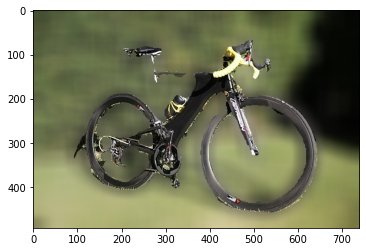

In [92]:
bi_concat = np.where(bi_img_mask_color==255, bicycle_orig, bi_bg_blur)

plt.imshow(cv2.cvtColor(bi_concat, cv2.COLOR_BGR2RGB))
plt.show()

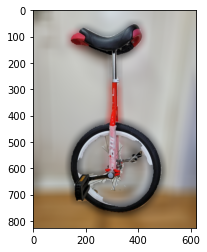

In [93]:
sg_concat = np.where(sg_img_mask_color==255, single_orig, sg_bg_blur)

plt.imshow(cv2.cvtColor(sg_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 두 자전거 모두 바퀴 안쪽의 살을 구분하지 못하는 모습을 보여줍니다.
- 어떻게 해결해야할까요?

## 6. 문제점 해결 방안

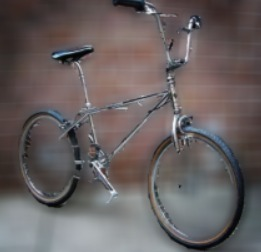

- 다시 위의 이미지를 확인해 보겠습니다.
- 바퀴 안쪽이 사라져있네요! 어떻게 해야 이것을 해결할 수 있을까요?

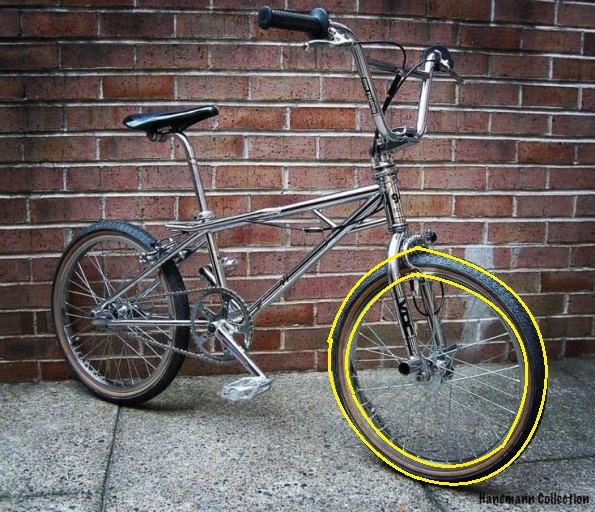

- 아마 모델의 output의 구분점이 위처럼 바퀴에 설정되어있는듯합니다.
- 저 구분점들을 수정해준다면 좋지 않을까 싶습니다.

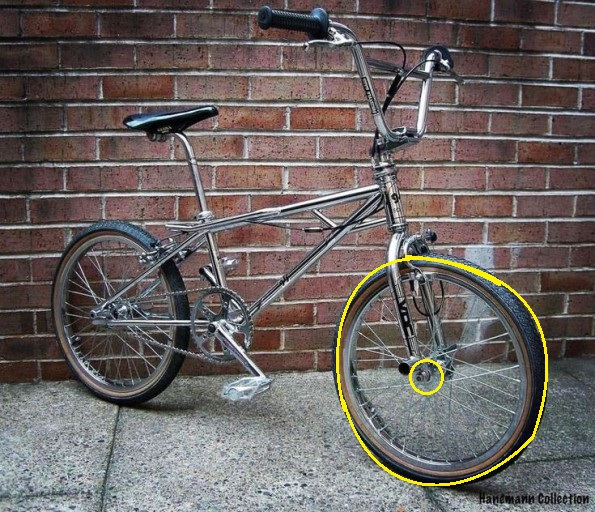

- 이런식으로 말이죠! 그렇다면 살도 구분해 내고 바퀴 안쪽도 잘 나타낼 수 있지 않을까요?
- 그림 실력이 모자라서 이렇게밖에 표현하지 못해 죄송합니다.

## 7. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트에선 원리 이해가 가장 어려웠습니다. 하지만 점점 진행할수록 이해가 되었고 생각보다 어렵진않구나 라고 생각하게 되었습니다. 하지만 마지막부분 문제점 찾기가 가장 어려웠습니다. 문제점이라고 할만한것들을 봤을 때 이것을 문제점이라고 할 수 있을까? 싶은 내용들이 많았고 문제점이라 생각한 것들도 부족한 지식때문에 해결방안으로 무엇을 제시할 수 있을까 싶었습니다. 때문에 결과적으로 모호하게 해결방안을 제시하게 된것같습니다. 아무래도 코드적인 부분보다는 이번엔 진짜 이미지라는 것에 좀 더 초점이 맞춰져있어 너무 다른 정보이기에 어려웠던듯 싶습니다.

### 이번 프로젝트에서 학습한 내용
>- 솔직히 이번 프로젝트에서 따로 학습한 내용은 거의 없습니다. 원리를 이해하기 위해 코드를 하나 하나 뜯어보게되었고 그 과정에서 함수들의 성능에 관하여 알게되었습니다.

### 알아낸 점이나 모호한 점
>- 솔직히 이번 프로젝트는 그렇게 재밌지도 않았고 흥미가 크게 생기지 않았으며 가장 많이 알게된것은 cv2의 함수들입니다. 공부한게 많지 않으니 모호하다거나 하는 부분은 크게 없는듯합니다. 굳이 찾아보자면 블러과정을 저렇게 복잡하게 해야할까 싶었습니다. 뭔가 간추릴 수 있는 방법이 있을듯합니다만.. 찾지 못하였고 차차 찾아볼 내용이라고 생각합니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.__ 에 관하여서는 사람, 말, 배경을 적용시켜보았고 이를 클래스화하여 간편하게 적용시킬 수 있도록 설정하였습니다. 
>- __2. 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.__ 2번 루브릭에서 말하는 인물사진에서 발생한 문제점중 자전거 인물모드 사진에서의 문제점을 지적하였으며 문제점을 표시한 사진을 첨부하였습니다.
>- __3. semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.__ 2번 루브릭과 동일하게 해결방법 또한 제시했습니다만 이게 오류를 보완할 수 있고 좋은 솔루션인지는 정확하게 판단하지 못하겠습니다만 제시하긴 하였습니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 3번 루브릭에서 달성하지 못하지 않았을까 싶습니다. 이유로는 솔루션으로 제시한 저의 의견이 과연 정말 좋은 솔루션일지? 그렇게 한다면 정말 오류를 해결할 수 있을지? 전혀 다른문제를 짚은건 아닌지 등등 여러 이유가 있기에 아무래도 달성하지 못했다면 저 부분이 아닐까 싶습니다.


## 8. Reference

- https://076923.github.io/posts/Python-opencv-32/ cv2.biwise 연산
- https://velog.io/@och9854/E-07-Image-Segmentation 참고 블로그
- https://github.com/ayoolaolafenwa/PixelLib pixellib 라이브러리 깃허브

## 9. 자기다짐 및 아쉬운 점

- 이번 프로젝트를 진행하면서 점점 의지를 잃어가는 듯한 느낌을 받게되었습니다. 흥미를 제대로 느끼지 못하니 더 공부하고 싶다는 생각도 들지 않게되고 무언가 동기부여가 필요한 시점이라는 것을 느끼게 되었습니다.
  
  
- 앞으로 관심분야를 확실히하고 조금의 exploration을 포기하고 흥미 위주의 분야 공부를 좀 더 하는게 좋지않을까 라는 생각을 하게 되었습니다.
  
  
- 이번 프로젝트에서 아쉬운 점은 제가 부족한 지식때문인지 부족한 흥미때문인지 모르겠으나 2,3번 루브릭에서 제시한 조건들이 코드적인 문제라던지 모델 등의 문제가 아닌 조금 더 전문적인 이미지 혹은 카메라? 와 관련된 지식을 요구하는것 같아 아쉬웠습니다. 분명 필요한 지식은 맞는것같으나 갑자기 너무 다른분야의 지식을 요구하니 조금 당황스럽기도 하여 이 부분이 가장 아쉬웠습니다.